# Laboratorio 4: Aprendizaje Supervisado

> **Análisis de las Posiciones del Aborto en Twitter**
> *Diplomatura en Ciencias de Datos, Aprendizaje Automático y sus aplicaciones.*
> *Integrantes: 
    - Carlos Piaggio
    - Juan Pablo Analian
    

- [Notebook 1](entrega_04_v7.ipynb)
- [Notebook 2](entrega_04_v8.ipynb)

## Parte 3/3 (modelos de RN)    

In [ ]:
#!pip install stop-words #https://pypi.org/project/stop-words/
#!pip install nltk

#import nltk

#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')

In [23]:
import pandas as pd
import re
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report 

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

## 1. Cargamos dataset que hemos limpiado en la notebook anterior


In [2]:
df_full = pd.read_csv('./out/df_text_junio.csv')

### Metodo auxiliar para graficar

In [3]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

### Largo de cada tweet

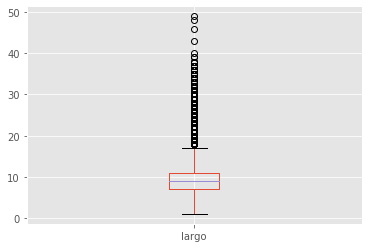

In [4]:
lista = df_full['text'].str.split().str.len()
df = pd.DataFrame({'largo': lista})
df.boxplot(column=['largo'])

In [5]:
df.describe()

,largo
count,1.041164e+06
mean,9.254663e+00
std,3.689159e+00
min,1.000000e+00
25%,7.000000e+00
50%,9.000000e+00
75%,1.100000e+01
max,4.900000e+01


### 4.Embeddings >  Bag of Words
Comenzamos a trabaja el texto de los tweets. 
Tomaremos un largo de 15 elementos por tweet, para contemplar mas del 75% de los tweets que tienen este largo o menos (ver tabla anterior)

In [6]:
# maximo numero de palabras a usar
VOCABULARY_SIZE = 100000

#  tomaremos 15 para  contemplar mas del 75% de los tweets que tienen este largo o menos
MAX_SEQUENCE_LENGTH = 15

tokenizer = Tokenizer(num_words=(VOCABULARY_SIZE))
tokenizer.fit_on_texts(df_full['text'].values)
#word_index = tokenizer.word_index

print('Se encontraron %s palabras unicas.' % len( tokenizer.word_index))
#cuando aplicamos text_to_sequence, usa solo las 100 mil primeras

Se encontraron 151551 palabras unicas.


### Armamos tensor de entrada para el modelo

In [7]:
X = tokenizer.texts_to_sequences(df_full['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('tamaño del tensor X:', X.shape)

tamaño del tensor X: (1041164, 15)


In [8]:
Y = df_full['codigo_posicion'].values
print('tamaño del tensor Y:', Y.shape)

tamaño del tensor Y: (1041164,)


### Separamos datos entre entrenamiento y validacion (80-20)

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(832931, 15) (832931,)
(208233, 15) (208233,)


## 2. Red neuronal simple con Keras

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

# salida de la 1era capa de embeddings
EMBEDDING_DIM = 10

model = Sequential()
model.add(layers.Embedding(input_dim=VOCABULARY_SIZE + 1, # cantidad maxima de palabras unicas (valores de indinces)
                           output_dim=EMBEDDING_DIM,  #salida, matriz densa.
                           input_length=MAX_SEQUENCE_LENGTH)) #elementos padeados de cada fila del feature = 15 
model.add(layers.Flatten())
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15, 10)            1000010   
_________________________________________________________________
flatten (Flatten)            (None, 150)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 755       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 1,000,771
Trainable params: 1,000,771
Non-trainable params: 0
_________________________________________________________________


In [11]:
history = model.fit(X_train, Y_train,
                    epochs=8,
                    verbose=True,
                    validation_data=(X_test, Y_test),
                    batch_size=1000)

loss, accuracy = model.evaluate(X_train, Y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test, Y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Train on 832931 samples, validate on 208233 samples
Epoch 1/8
832931/832931 [==============================] - 7s 8us/sample - loss: 0.2005 - accuracy: 0.9184 - val_loss: 0.1036 - val_accuracy: 0.9580
Epoch 2/8
832931/832931 [==============================] - 6s 7us/sample - loss: 0.0790 - accuracy: 0.9690 - val_loss: 0.0888 - val_accuracy: 0.9646
Epoch 3/8
832931/832931 [==============================] - 6s 7us/sample - loss: 0.0554 - accuracy: 0.9790 - val_loss: 0.0889 - val_accuracy: 0.9655
Epoch 4/8
832931/832931 [==============================] - 6s 8us/sample - loss: 0.0421 - accuracy: 0.9841 - val_loss: 0.0934 - val_accuracy: 0.9659
Epoch 5/8
832931/832931 [==============================] - 6s 7us/sample - loss: 0.0338 - accuracy: 0.9874 - val_loss: 0.1008 - val_accuracy: 0.9659
Epoch 6/8
832931/832931 [==============================] - 6s 7us/sample - loss: 0.0282 - accuracy: 0.9894 - val_loss: 0.1094 - val_accuracy: 0.9660
Epoch 7/8
832931/832931 [=============================

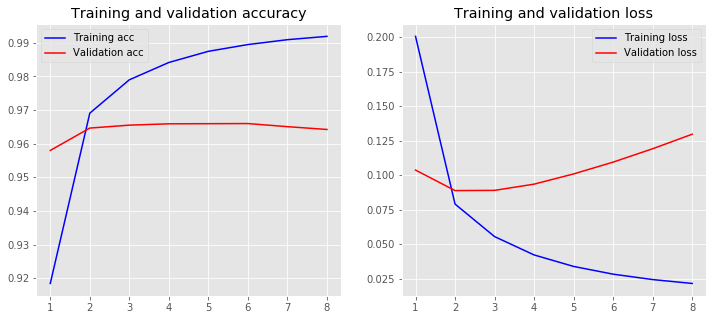

In [12]:
plot_history(history)

## 3 Keras  (dropout + LSTM)

SpatialDropout hace dropout variados.

La capa LSTM puede aprender dependencias largas, (como una "memoria" a largo plazo)

In [13]:
model = Sequential()

model.add(Embedding(input_dim=VOCABULARY_SIZE + 1, # cantidad maxima de palabras unicas (valores de indinces)
                           output_dim=EMBEDDING_DIM,  #salida, matriz densa.
                           input_length=MAX_SEQUENCE_LENGTH)) #elementos padeados de cada fila del feature = 15 
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 15, 10)            1000010   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 15, 10)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               44400     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 505       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 1,044,921
Trainable params: 1,044,921
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
history = model.fit(X_train, Y_train,
                    epochs=8,
                    verbose=True,
                    validation_data=(X_test, Y_test),
                    batch_size=1000)

loss, accuracy = model.evaluate(X_train, Y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test, Y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Train on 832931 samples, validate on 208233 samples
Epoch 1/8
832931/832931 [==============================] - 55s 66us/sample - loss: 0.2722 - accuracy: 0.8820 - val_loss: 0.1285 - val_accuracy: 0.9512
Epoch 2/8
832931/832931 [==============================] - 51s 62us/sample - loss: 0.1139 - accuracy: 0.9583 - val_loss: 0.1105 - val_accuracy: 0.9585
Epoch 3/8
832931/832931 [==============================] - 51s 62us/sample - loss: 0.0941 - accuracy: 0.9664 - val_loss: 0.1059 - val_accuracy: 0.9620
Epoch 4/8
832931/832931 [==============================] - 49s 59us/sample - loss: 0.0842 - accuracy: 0.9698 - val_loss: 0.1041 - val_accuracy: 0.9629
Epoch 5/8
832931/832931 [==============================] - 49s 59us/sample - loss: 0.0763 - accuracy: 0.9726 - val_loss: 0.1022 - val_accuracy: 0.9635
Epoch 6/8
832931/832931 [==============================] - 50s 60us/sample - loss: 0.0706 - accuracy: 0.9744 - val_loss: 0.0989 - val_accuracy: 0.9643
Epoch 7/8
832931/832931 [=================

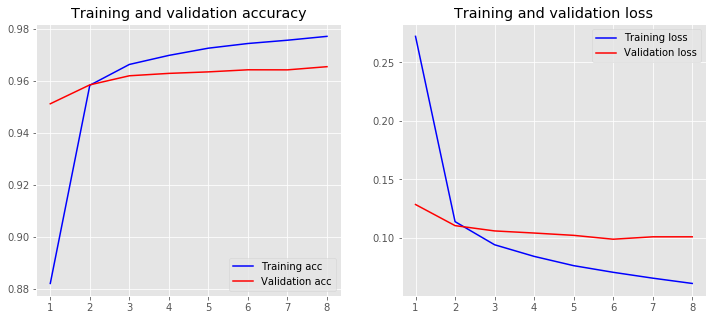

In [15]:
plot_history(history)

## 4. Usando diccionarios pre-entrenados

In [19]:
import numpy as np
#funcion auxiliar
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [20]:
embedding_dim = 300
embedding_matrix = create_embedding_matrix(
     './data/glove-sbwc.i25.vec',
     tokenizer.word_index, embedding_dim)


In [22]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / VOCABULARY_SIZE #How many of the embedding vectors are nonzero

0.49456

> Sólo el 49% de las palabras presentes en el dataset se encuentran en este "corpus". Creemos que no es sufiente el porcentaje para utilizarlo.